# Intro to Deep Learning Systems: Lab 4

In [9]:
import json
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import torch.nn as nn
from tqdm import tqdm
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision.io import read_image
from torchvision import transforms
from pathlib import Path

## Q1.1a
### Load Dataset

In [2]:
class DecalCIFAR100(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.data = self._make_dataset(img_dir, annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def _make_dataset(self, img_dir, annotations_file):
        with open(annotations_file) as f:
            self.meta_data = json.load(f)
            
        meta_img, meta_annot, meta_cat = pd.DataFrame(self.meta_data["images"]), self.meta_data["annotations"], self.meta_data["categories"]
        meta_img = meta_img.set_index("id")
        
        data = []
        for row in meta_annot:
            image, category = meta_img.loc[int(row["image_id"])]["file_name"], int(row["category_id"])
            img_path = Path(img_dir) / image.lstrip("data/")
            data.append({"File Path": img_path, "Label": int(category)})
        
        data = pd.DataFrame(data)
        
        min_cat = min(data["Label"])
        data["Label"] = data["Label"] - min_cat  # Categories from '20000001' onwards need to be standardized
        self.label_map = {int(row["id"]) - min_cat : row["name"] for row in meta_cat}
        self._l_data = len(data)
        return data

    def __len__(self):
        return self._l_data

    def __getitem__(self, idx):
        img_path, label = self.data.iloc[idx]
        image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# Data Paths
dataset_name = "cifar100"
annotations_path = Path("annotations")
train_annotations = annotations_path / f"{dataset_name}_train.json"
val_annotations = annotations_path / f"{dataset_name}_val.json"
test_annotations = annotations_path / f"{dataset_name}_test_stripped.json"
data_path = Path("data")

In [4]:
cifar100_train_ds = DecalCIFAR100(annotations_file=str(train_annotations), img_dir = str(data_path))
cifar100_val_ds = DecalCIFAR100(annotations_file=str(val_annotations), img_dir = str(data_path))
labels_map = cifar100_train_ds.label_map

### Describe Dataset

In [5]:
print(f"Dataset Name: {dataset_name}")
labels_df = pd.DataFrame([{"Label": label, "Class": name} for label, name in labels_map.items()])
cifar_df = cifar100_train_ds.data
class_df = pd.merge(cifar_df, labels_df, how="inner")

pd.set_option('display.max_rows', class_df.shape[0]+1)

class_counts = class_df["Class"].value_counts()
print(f"Number of classes: {class_counts.shape[0]}")
print(f"Image distribution per class:")
class_counts

Dataset Name: cifar100
Number of classes: 100
Image distribution per class:


apple            400
porcupine        400
shark            400
seal             400
sea              400
rose             400
rocket           400
road             400
ray              400
raccoon          400
rabbit           400
possum           400
poppy            400
aquarium_fish    400
plate            400
plain            400
pine_tree        400
pickup_truck     400
pear             400
palm_tree        400
otter            400
orchid           400
orange           400
oak_tree         400
shrew            400
skunk            400
skyscraper       400
snail            400
woman            400
wolf             400
willow_tree      400
whale            400
wardrobe         400
turtle           400
tulip            400
trout            400
train            400
tractor          400
tiger            400
television       400
telephone        400
tank             400
table            400
sweet_pepper     400
sunflower        400
streetcar        400
squirrel         400
spider       

In [6]:
pd.set_option('display.max_rows', 10)

### Sample Images

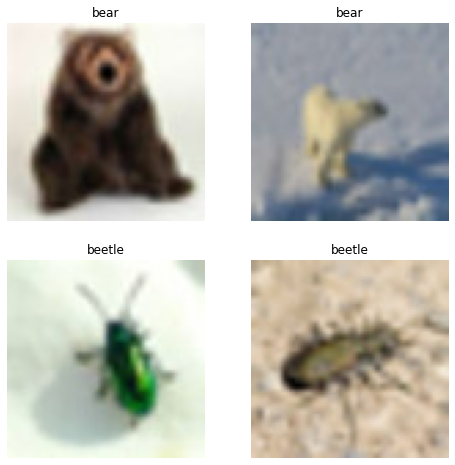

In [7]:
cols, rows = 2, 2
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sample_labels = [3, 7]

for i in range(rows):
    sample_idx = list(cifar_df.index[cifar_df["Label"] == sample_labels[i]])[:2]
    for j, idx in enumerate(sample_idx):
        img, label = cifar100_train_ds[idx]
        axes[i][j].set_title(labels_map[label])
        axes[i][j].axis("off")
        axes[i][j].imshow(img.permute(1, 2, 0))
plt.show()

### Modify Pretrained Model

In [8]:
def fine_tune_model(base_model, initial_lr):
    model_ft = base_model
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 100)  # Set output features for full-connected layer to 100 (for cifar100)
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=initial_lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    n_epochs = 200
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=[60, 120, 180])
    
    model_ft = train_model(model_ft, criterion, optimizer_ft, lr_scheduler, num_epochs=n_epochs)
    
    return model_ft

## Q1.1b

In [15]:
# Params
batch_size = 64

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {"train": cifar100_train_ds, "val": cifar100_val_ds}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Finetune the model via training on CIFAR100

In [15]:
model_ft = fine_tune_model(models.resnet50(pretrained=True), 1e-3)

Epoch 0/199
----------
train Loss: 2.1094 Acc: 0.5003
val Loss: 1.1214 Acc: 0.6741
Epoch 1/199
----------
train Loss: 0.8510 Acc: 0.7491
val Loss: 0.9047 Acc: 0.7250
Epoch 2/199
----------
train Loss: 0.5080 Acc: 0.8502
val Loss: 0.8589 Acc: 0.7457
Epoch 3/199
----------
train Loss: 0.2957 Acc: 0.9158
val Loss: 0.8883 Acc: 0.7453
Epoch 4/199
----------
train Loss: 0.1706 Acc: 0.9568
val Loss: 0.8934 Acc: 0.7570
Epoch 5/199
----------
train Loss: 0.0965 Acc: 0.9797
val Loss: 0.9199 Acc: 0.7530
Epoch 6/199
----------
train Loss: 0.0578 Acc: 0.9900
val Loss: 0.9183 Acc: 0.7655
Epoch 7/199
----------
train Loss: 0.0373 Acc: 0.9948
val Loss: 0.9508 Acc: 0.7609
Epoch 8/199
----------
train Loss: 0.0258 Acc: 0.9971
val Loss: 0.9507 Acc: 0.7655
Epoch 9/199
----------
train Loss: 0.0195 Acc: 0.9979
val Loss: 0.9880 Acc: 0.7607
Epoch 10/199
----------
train Loss: 0.0157 Acc: 0.9984
val Loss: 0.9829 Acc: 0.7671
Epoch 11/199
----------
train Loss: 0.0129 Acc: 0.9987
val Loss: 0.9964 Acc: 0.7689
Ep

## Q1.1c
### Learning Rate 0.01

In [24]:
model_ft_lr001 = fine_tune_model(models.resnet50(pretrained=True), 1e-2)

Epoch 0/199
----------
train Loss: 1.9019 Acc: 0.4961
val Loss: 1.5573 Acc: 0.5761
Epoch 1/199
----------
train Loss: 1.0864 Acc: 0.6804
val Loss: 1.5169 Acc: 0.5895
Epoch 2/199
----------
train Loss: 0.7411 Acc: 0.7724
val Loss: 1.6037 Acc: 0.5859
Epoch 3/199
----------
train Loss: 0.5177 Acc: 0.8375
val Loss: 1.6026 Acc: 0.6174
Epoch 4/199
----------
train Loss: 0.4134 Acc: 0.8685
val Loss: 1.4997 Acc: 0.6405
Epoch 5/199
----------
train Loss: 0.3003 Acc: 0.9031
val Loss: 1.4532 Acc: 0.6580
Epoch 6/199
----------
train Loss: 0.2053 Acc: 0.9321
val Loss: 1.6098 Acc: 0.6509
Epoch 7/199
----------
train Loss: 0.1943 Acc: 0.9365
val Loss: 1.6219 Acc: 0.6514
Epoch 8/199
----------
train Loss: 0.1398 Acc: 0.9545
val Loss: 1.6400 Acc: 0.6646
Epoch 9/199
----------
train Loss: 0.1056 Acc: 0.9663
val Loss: 1.7133 Acc: 0.6581
Epoch 10/199
----------
train Loss: 0.0864 Acc: 0.9724
val Loss: 1.6729 Acc: 0.6720
Epoch 11/199
----------
train Loss: 0.0792 Acc: 0.9745
val Loss: 1.6223 Acc: 0.6802
Ep

### Learning Rate 0.1

In [11]:
model_ft_lr01 = fine_tune_model(models.resnet50(pretrained=True), 1e-1)

Epoch 0/199
----------
train Loss: 4.2531 Acc: 0.0512
val Loss: 3.8458 Acc: 0.0939
Epoch 1/199
----------
train Loss: 3.5627 Acc: 0.1449
val Loss: 3.3179 Acc: 0.1950
Epoch 2/199
----------
train Loss: 3.0721 Acc: 0.2380
val Loss: 3.5385 Acc: 0.1928
Epoch 3/199
----------
train Loss: 2.7175 Acc: 0.3083
val Loss: 2.7076 Acc: 0.3205
Epoch 4/199
----------
train Loss: 2.4128 Acc: 0.3717
val Loss: 2.6859 Acc: 0.3293
Epoch 5/199
----------
train Loss: 2.1280 Acc: 0.4327
val Loss: 2.4619 Acc: 0.3729
Epoch 6/199
----------
train Loss: 1.8894 Acc: 0.4862
val Loss: 2.6391 Acc: 0.3556
Epoch 7/199
----------
train Loss: 1.6004 Acc: 0.5565
val Loss: 2.3051 Acc: 0.4171
Epoch 8/199
----------
train Loss: 1.3264 Acc: 0.6215
val Loss: 2.5314 Acc: 0.3901
Epoch 9/199
----------
train Loss: 1.0990 Acc: 0.6782
val Loss: 2.5144 Acc: 0.4149
Epoch 10/199
----------
train Loss: 0.7793 Acc: 0.7668
val Loss: 2.7669 Acc: 0.3984
Epoch 11/199
----------
train Loss: 0.5284 Acc: 0.8409
val Loss: 2.7259 Acc: 0.4180
Ep

The learning rate **0.001** gives the highest accuracy.

## Q1.2a

In [15]:
model_ext_1 = transfer_learn(models.resnet50(pretrained=True), 1, fixed_extract=True)

Epoch 0/199
----------
train Loss: 95.6782 Acc: 0.3253
val Loss: 86.7004 Acc: 0.3904
Epoch 1/199
----------
train Loss: 75.3866 Acc: 0.4243
val Loss: 86.7201 Acc: 0.4063
Epoch 2/199
----------
train Loss: 70.5082 Acc: 0.4592
val Loss: 89.3746 Acc: 0.4142
Epoch 3/199
----------
train Loss: 68.1898 Acc: 0.4763
val Loss: 88.3023 Acc: 0.4329
Epoch 4/199
----------
train Loss: 63.7868 Acc: 0.4968
val Loss: 84.4346 Acc: 0.4497
Epoch 5/199
----------
train Loss: 59.9139 Acc: 0.5145
val Loss: 84.5138 Acc: 0.4583
Epoch 6/199
----------
train Loss: 57.8107 Acc: 0.5279
val Loss: 86.1414 Acc: 0.4591
Epoch 7/199
----------
train Loss: 54.6106 Acc: 0.5405
val Loss: 85.1672 Acc: 0.4603
Epoch 8/199
----------
train Loss: 53.3362 Acc: 0.5495
val Loss: 88.9887 Acc: 0.4475
Epoch 9/199
----------
train Loss: 51.6701 Acc: 0.5601
val Loss: 89.6850 Acc: 0.4524
Epoch 10/199
----------
train Loss: 49.1187 Acc: 0.5703
val Loss: 86.2470 Acc: 0.4636
Epoch 11/199
----------
train Loss: 47.4769 Acc: 0.5792
val Loss

In [16]:
model_ext_01 = transfer_learn(models.resnet50(pretrained=True), 1e-1, fixed_extract=True)

Epoch 0/199
----------
train Loss: 7.3371 Acc: 0.3424
val Loss: 8.1837 Acc: 0.3894
Epoch 1/199
----------
train Loss: 6.8430 Acc: 0.4296
val Loss: 8.0081 Acc: 0.4221
Epoch 2/199
----------
train Loss: 6.5457 Acc: 0.4605
val Loss: 8.1770 Acc: 0.4300
Epoch 3/199
----------
train Loss: 6.0011 Acc: 0.4920
val Loss: 7.4979 Acc: 0.4478
Epoch 4/199
----------
train Loss: 5.7492 Acc: 0.5071
val Loss: 7.6863 Acc: 0.4475
Epoch 5/199
----------
train Loss: 5.3600 Acc: 0.5260
val Loss: 7.6726 Acc: 0.4473
Epoch 6/199
----------
train Loss: 5.2196 Acc: 0.5380
val Loss: 8.1886 Acc: 0.4548
Epoch 7/199
----------
train Loss: 5.0373 Acc: 0.5477
val Loss: 7.8364 Acc: 0.4546
Epoch 8/199
----------
train Loss: 4.6915 Acc: 0.5644
val Loss: 8.1826 Acc: 0.4632
Epoch 9/199
----------
train Loss: 4.5912 Acc: 0.5711
val Loss: 7.8632 Acc: 0.4612
Epoch 10/199
----------
train Loss: 4.4191 Acc: 0.5822
val Loss: 8.5232 Acc: 0.4598
Epoch 11/199
----------
train Loss: 4.1065 Acc: 0.5962
val Loss: 7.8866 Acc: 0.4727
Ep

In [17]:
model_ext_001 = transfer_learn(models.resnet50(pretrained=True), 1e-2, fixed_extract=True)

Epoch 0/199
----------
train Loss: 2.3463 Acc: 0.4149
val Loss: 1.9821 Acc: 0.4810
Epoch 1/199
----------
train Loss: 1.8137 Acc: 0.5178
val Loss: 1.9328 Acc: 0.4990
Epoch 2/199
----------
train Loss: 1.6626 Acc: 0.5530
val Loss: 1.8915 Acc: 0.5086
Epoch 3/199
----------
train Loss: 1.5740 Acc: 0.5703
val Loss: 1.8358 Acc: 0.5196
Epoch 4/199
----------
train Loss: 1.5034 Acc: 0.5874
val Loss: 1.8870 Acc: 0.5157
Epoch 5/199
----------
train Loss: 1.4404 Acc: 0.6017
val Loss: 1.8783 Acc: 0.5216
Epoch 6/199
----------
train Loss: 1.4037 Acc: 0.6112
val Loss: 1.8942 Acc: 0.5213
Epoch 7/199
----------
train Loss: 1.3489 Acc: 0.6210
val Loss: 1.8475 Acc: 0.5216
Epoch 8/199
----------
train Loss: 1.3168 Acc: 0.6285
val Loss: 1.8444 Acc: 0.5289
Epoch 9/199
----------
train Loss: 1.2709 Acc: 0.6406
val Loss: 1.8821 Acc: 0.5235
Epoch 10/199
----------
train Loss: 1.2375 Acc: 0.6466
val Loss: 1.8587 Acc: 0.5264
Epoch 11/199
----------
train Loss: 1.2062 Acc: 0.6528
val Loss: 1.8883 Acc: 0.5270
Ep

In [18]:
model_ext_0001 = transfer_learn(models.resnet50(pretrained=True), 1e-3, fixed_extract=True)

Epoch 0/199
----------
train Loss: 3.3472 Acc: 0.3069
val Loss: 2.5556 Acc: 0.4314
Epoch 1/199
----------
train Loss: 2.3321 Acc: 0.4624
val Loss: 2.1791 Acc: 0.4669
Epoch 2/199
----------
train Loss: 2.0700 Acc: 0.4919
val Loss: 2.0523 Acc: 0.4815
Epoch 3/199
----------
train Loss: 1.9362 Acc: 0.5126
val Loss: 1.9673 Acc: 0.4937
Epoch 4/199
----------
train Loss: 1.8450 Acc: 0.5285
val Loss: 1.9178 Acc: 0.5022
Epoch 5/199
----------
train Loss: 1.7805 Acc: 0.5409
val Loss: 1.8887 Acc: 0.5079
Epoch 6/199
----------
train Loss: 1.7337 Acc: 0.5497
val Loss: 1.8546 Acc: 0.5108
Epoch 7/199
----------
train Loss: 1.6972 Acc: 0.5566
val Loss: 1.8211 Acc: 0.5186
Epoch 8/199
----------
train Loss: 1.6615 Acc: 0.5631
val Loss: 1.8300 Acc: 0.5139
Epoch 9/199
----------
train Loss: 1.6305 Acc: 0.5679
val Loss: 1.8122 Acc: 0.5166
Epoch 10/199
----------
train Loss: 1.6048 Acc: 0.5760
val Loss: 1.7982 Acc: 0.5222
Epoch 11/199
----------
train Loss: 1.5842 Acc: 0.5802
val Loss: 1.7862 Acc: 0.5263
Ep

The learning rate **0.001** gives the highest accuracy.

## Q1.2b
Out of all the approaches and learning rates, the combination of finetuning the entire model with a low learning rate of **0.001** gives the highest validation accuracy.

This is expected as:
- The finetuning approach tunes the entire model from an initial set of pretrained weights. Compared to the feature-extraction approach, this method is likely converge more as the entire network is being tuned on our training dataset.
- The low learning rate is essential for transfer learning as we do not want the model weights to drift drastically away from the pretrained model weights as that would negate the advantage of having highly trained feature extractions from the pretrained model. The slow learning rate helps tune the network without destroying the pretrained model.

## Q2.1
**Weakly Supervised** pretraining directly uses *noisy labeled* datasets, i.e., datasets sourced from publicly available and weakly annotated data (for example, hashtagged images from Instagram) to pretrain convnets which are subsequently used as precursors for transfer learning to certain target datasets.

**Semi-Supervised** pretraining involves using the same Instagram dataset to pretrain the *Teacher Model* which was then finetuned on Imagenet to be used to classify the unlabeled images for the *Student Model* training. 

The key difference here is that in **semi-supervised** variant, the hashtagged Instagram dataset is being used to pretrain the *Teacher Model* which is then fintuned and used to generate training data for subsequent steps, whereas in the **weakly supervised** model, the fintuned model is considered final.

## Q2.2a
Based on the paper by Mahajan et al, models trained using hastags are robust to noise in labels.

This was confirmed by the image classificartion experiments where the effect of injecting additional label noise on the accuracy of our networks is investigated. To do so, Mahajan et al pretrain ResNeXt-101 32×16d networks on a version of IG-1B-17k in which they randomly replaced p% of the hashtags by hashtags obtained by sampling from the marginal distribution over hashtags (excluding the tag to be replaced). 

The results suggest that the networks are remarkably resilient against label noise: a noise level of p = 10% leads to a loss of less than 1% in classification accuracy, and at p = 25% label noise, the reduction in accuracy is around 2%.

## Q2.2b
The results show that resampling of the hashtag distribution is important in order to obtain good transfer to ImageNet image-classification tasks: using uniform or square-root sampling leads to an accuracy improvement of 5 to 6% irrespective of the number of ImageNet classes in the transfer task.

## Q2.3a
In **semi-supervised** learning, we use the **Teacher-Student** architecture to leverage unlabeled data for our training.

The **Teacher Model** is trained initially on a labeled dataset (like Imagenet) and then used to generate *pseudo*-label probabilities for an unlabeled dataset.

Out of these pseudo-labeled images, we pick a certain subset of classes and images with the highest probabilities and use them to pretrain a **Student Model** which is then finetuned on the original labeled dataset.

The **distillation** procedure amounts to training the small model (the student) such that it reproduces at best the output of the teacher, which is essentially what we observe in **semi-supervised** learning. Distillation can be seen as a particular case of self-training, in that the teacher model makes prediction on unlabelled data, and the inferred labels are used to train the student in a supervised fashion.

## Q2.3b
The parameter `P` represents the top **P** classes selected from the pseudo-labeled imaged classifed by the *Teacher* model to be used to train the *Student Model*.

The parameter `K` represents the top **K** images from each of the **P** classes selected to be used to train the *Student Model*.

We consider values for $P>1$ primarily because:
- We need more training data for certain under-represented classes (with lower classification probabilities).
- Some highly frequent labels might dominate the selected subsets if the $P$ value is too low or $1$.

## Q2.3c
We use the *Teacher* model, which is trained on a labeled dataset like ImageNet to predict classification scores for the unlabeled data.

Since every image has classification scores for each of the target classes, we can have cases where an image belongs to multiple clases if the scores are close to each other.

## Q2.3d
As we increase the value of $K$, the training dataset size for the *student* model increases as is expected of any machine learning model. However, since this dataset consists of *pseudo*-labeled images, the larger the $K$ value, the more the chance we include images with low prediction (classification) scores, which means introducing noisy data into thr training set. Hence, beyond a certain point, increasing $K$ serves to increase noise in the training of the *student* model, thereby decreasing its accuracy.

## Q3.1
Achieving peak FLOPs is a difficult proposition, usually requiring customized libraries developed by organizations with intimate knowledge of the underlying hardware, e.g., Intel’s MKL (int, 2009), ATLAS (Whaley & Petitet, 2005), and cuDNN. Even these specially tuned libraries may fall short of peak execution by as much as 40% (atl). Further, any computation done outside the scope of PALEO (e.g. job scheduling, data copying) will exacerbate the observed inefficiency in practice.

Rather than trying to measure and capture every source of inefficiency in every learning framework, for PPP, we take a small number of representative deep learning workloads which contain convolutions, pooling, dropout, and fully connected layers and run them for a short time on a single GPU. Given observed total throughput and estimated total throughput on this benchmark we fit a scaling constant to estimate PPP parameter which captures the average relative inefficiency of the platform compared to peak FLOPS. Highly specialized frameworks (e.g. cuDNN) will in general have a computational PPP that is close to 100%, while frameworks with higher overheads may have PPP constants closer to 50% or less.

## Q3.2

In [27]:
from ptflops import get_model_complexity_info
net = models.vgg19().to(device)

macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)

print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

VGG(
  143.667 M, 100.000% Params, 19.668 GMac, 100.000% MACs, 
  (features): Sequential(
    20.024 M, 13.938% Params, 19.544 GMac, 99.371% MACs, 
    (0): Conv2d(0.002 M, 0.001% Params, 0.09 GMac, 0.457% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0.0 M, 0.000% Params, 0.003 GMac, 0.016% MACs, inplace=True)
    (2): Conv2d(0.037 M, 0.026% Params, 1.853 GMac, 9.421% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0.0 M, 0.000% Params, 0.003 GMac, 0.016% MACs, inplace=True)
    (4): MaxPool2d(0.0 M, 0.000% Params, 0.003 GMac, 0.016% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(0.074 M, 0.051% Params, 0.926 GMac, 4.710% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.008% MACs, inplace=True)
    (7): Conv2d(0.148 M, 0.103% Params, 1.851 GMac, 9.413% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

As shown above, the **VGG19** network has a total of $19.67$ GFLOPs (printed as `GMac`) on computations and a total of $19.523$ GFLOPs corresponding to convolutional layers. This makes the convolutional layers responsible for $~99.252%$ of all computations on VGG19.

## Q3.3
The reason for the mismatch is that CUDA supports asynchronous programming. Before time measurement, an API (`cudaDeviceSynchronize`) has to be called to make sure that all cores have finished their tasks. This explicit synchronization is the overhead of measuring time on the GPUs. Therefore, the sum of layerwise timing on GPUs is longer than a full forward pass.

The idea of mitigating the measurement overhead is simple. To benchmark a matrix multiplication, we keep GPUs iteratively running the matrix multiplication in a way that GPU cores can continuously perform multiply-add operations without synchronization, before recording the end time. Then, the measurement overhead is amortized over all the iterations, giving accurate timing estimates. This is done as follows.

Timing measurements on GPUs can only been recorded after all cores finish their tasks. In a full forward pass, timing is only recorded at the last layer. Therefore, a core may be assigned with the computation of following layers and thus it can continuously perform the computation without synchronization. For example, after finishing the multiply-add operations for the matrix multiplication at a CONV layer, a core can continue to calculate the max function of next ReLU layer on the output of multiply-add operations. If layerwise timing is recorded, all cores have to wait until all multiply-add operations of the CONV layer have been completed.

## Q3.4
#### Inference Time
Peak Single Precision Performance = 5.6 Tflops <br>
Peak Double Precision Performance = 1.87 Tflops

**VGG16**<br>
Num. FLOPs = 15503M = 0.015503 TFLOPs <br>
Single Precision Inference Time $= \frac{0.015503}{5.6} = 2.768 ms$<br>
Double Precision Inference Time $= \frac{0.015503}{1.87} = 8.29 ms$

**GoogleNet**<br>
Num. FLOPs = 1606M = 0.001606 TFLOPs <br>
Single Precision Inference Time $= \frac{0.001606}{5.6} = 0.2867 ms$<br>
Double Precision Inference Time $= \frac{0.001606}{1.87} = 0.8588 ms$

**Resnet**
Num. FLOPs = 3922M = 0.003922 TFLOPs <br>
Single Precision Inference Time $= \frac{0.003922}{5.6} = 0.7 ms$<br>
Double Precision Inference Time $= \frac{0.003922}{1.87} = 2.097 ms$

## Q4.1

In [1]:
import torchvision.datasets as datasets
from torchvision.models.resnet import _resnet, BasicBlock

### Define Resnet Variants

In [11]:
def resnet14():
    return _resnet("resnet14", BasicBlock, [1, 2, 2, 1], pretrained=False, progress=True)

def resnet18():
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained=False, progress=True)

def resnet20():
    return _resnet("resnet20", BasicBlock, [2, 2, 3, 2], pretrained=False, progress=True)

def resnet32():
    return _resnet("resnet32", BasicBlock, [3, 4, 4, 4], pretrained=False, progress=True)

def resnet44():
    return _resnet("resnet44", BasicBlock, [5, 5, 6, 5], pretrained=False, progress=True)

def resnet50():
    return _resnet("resnet50", BasicBlock, [6, 6, 6, 6], pretrained=False, progress=True)

def resnet56():
    return _resnet("resnet56", BasicBlock, [6, 7, 7, 7], pretrained=False, progress=True)

In [3]:
def train_Q4(model, criterion, optimizer, num_epochs, dataloader, verbose=True, partial_results=None):
      
    if not partial_results is None:
        train_accuracy_tracker = partial_results['train_accuracy']
        train_loss_tracker = partial_results['train_loss']
        time_tracker = partial_results['time']
    else:
        train_accuracy_tracker = []
        train_loss_tracker = []
        time_tracker = []

    model.train()

    for epoch in range(num_epochs-len(train_accuracy_tracker)):
        if (verbose == True) & (epoch % 10 == 0):
            print()
            print('Epoch', len(train_accuracy_tracker))

        train_loss = 0.0
        train_num_correct = 0
        train_num_samples = 0

        startTime = time.time()

        for i, (inputs, target) in enumerate(dataloader):

            # Track batch size
            batch_size = inputs.shape[0]
          
            # Move data to the GPU
            inputs = inputs.to(device)
            target = target.to(device)

            # Calculate logits and loss
            outputs = model(inputs)
            loss = criterion(outputs, target)

            # Calculate gradients and step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate and evaluate accuracy
            preds = torch.argmax(outputs, dim=1)
            train_num_correct += torch.sum(preds == target)
            train_num_samples += batch_size
                        
            # Update loss
            train_loss += loss.data * batch_size

        endTime = time.time()

        # Calculate accuracy
        epoch_train_accuracy = (train_num_correct / train_num_samples)*100
        train_accuracy_tracker.append(epoch_train_accuracy.item())
        if (verbose == True) & (epoch % 10 == 0):
            print('Train accuracy:', epoch_train_accuracy.item())

        # Calculate loss
        epoch_train_loss = train_loss / train_num_samples
        train_loss_tracker.append(epoch_train_loss.item())
        if (verbose == True) & (epoch % 10 == 0):
            print('Training loss:', epoch_train_loss.item())

        # Calculate time
        epoch_time_taken = endTime - startTime
        time_tracker.append(epoch_time_taken)

        if epoch%10==9:
            PATH = f'drive/MyDrive/3033/HW4_Q4_depth{depth}_gpuK80.pth'
            torch.save(model.state_dict(), PATH)

            results = {'train_accuracy': train_accuracy_tracker,
                      'train_loss': train_loss_tracker,
                      'time': time_tracker}

            with open(f'drive/MyDrive/3033/HW4_Q4_depth{depth}_gpuK80.json', "w") as outfile:
                json.dump(results, outfile)

    clear_output()

    return {'train_accuracy': train_accuracy_tracker,
            'train_loss': train_loss_tracker,
            'time': time_tracker}

In [12]:
# Load CIFAR-10 data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

6.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

12.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

18.8%IOPub m

Files already downloaded and verified


In [16]:
# Set parameters
num_epochs = 350
lr = 0.1
momentum = 0.9
weight_decay = 0.0001

depth = 50

# Initialize model
if depth == 14:
    model = resnet14().to(device)
elif depth == 18:
    model = resnet18().to(device)
elif depth == 20:
    model = resnet20().to(device)
elif depth == 32:
    model = resnet32().to(device)
elif depth == 44:
    model = resnet44().to(device)
elif depth == 50:
    model = resnet50().to(device)
elif depth == 56:
    model = resnet56().to(device)
    
# Initialize loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
# Train and save results
results = train_Q4(model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, dataloader=trainloader, verbose=True, partial_results=None)

### Loading all the 15 experiment data and calibrate optimus parameters

Resnet14 K80

beta0 = 0.34675920418625494
beta1 = 0.2771319414433547
beta2 = 0.04722729386644145


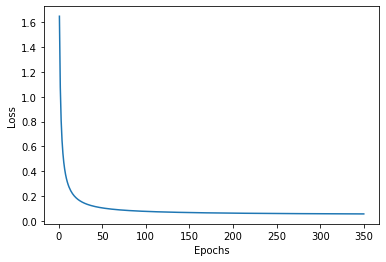

Resnet14 RTX8000

beta0 = 0.3604557900730088
beta1 = 0.27534735447141934
beta2 = 0.04776791412199516


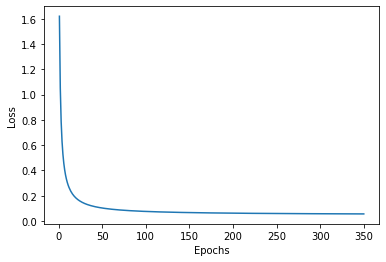

Resnet14 V100

beta0 = 0.344277735214861
beta1 = 0.27990219336286143
beta2 = 0.047213086242637994


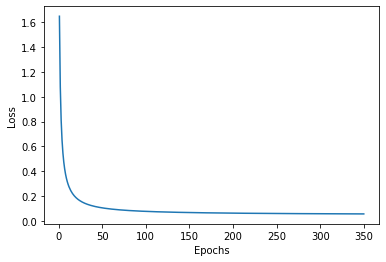

Resnet20 K80

beta0 = 0.2653126000697009
beta1 = 0.20910018415197001
beta2 = 0.043889250821160034


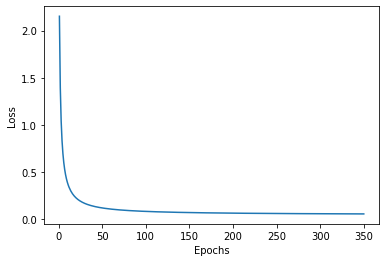

Resnet20 RTX8000

beta0 = 0.27771278956671464
beta1 = 0.2005330640282546
beta2 = 0.04296274377631923


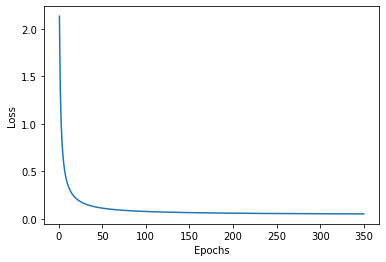

Resnet20 V100

beta0 = 0.29518216158894817
beta1 = 0.20821833984761254
beta2 = 0.045826684906138136


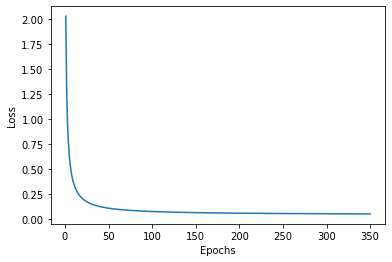

Resnet32 K80

beta0 = 0.1124890575443745
beta1 = 0.26122514538824476
beta2 = 0.016717836070514584


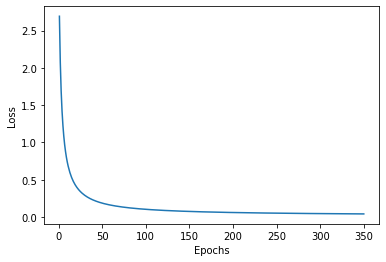

Resnet32 RTX8000

beta0 = 0.1463874018256248
beta1 = 0.22188336456943292
beta2 = 0.02739749966398438


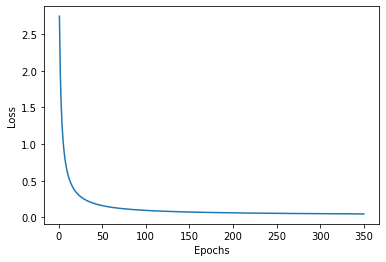

Resnet32 V100

beta0 = 0.18524658043197892
beta1 = 0.20483733106851396
beta2 = 0.035254933333763595


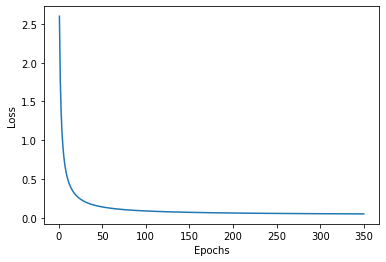

Resnet44 K80

beta0 = 0.10439041725556777
beta1 = 0.25287940346792015
beta2 = 0.011438178593084715


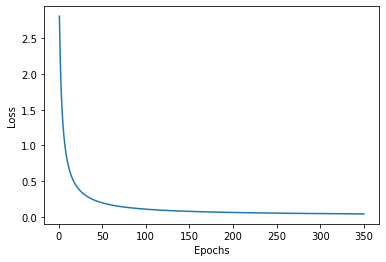

Resnet44 RTX8000

beta0 = 0.15089759296110672
beta1 = 0.20454671980274092
beta2 = 0.03158698664906838


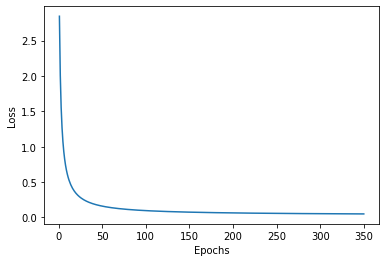

Resnet44 V100

beta0 = 0.09840475311461135
beta1 = 0.2538875018276165
beta2 = 0.011749946828492314


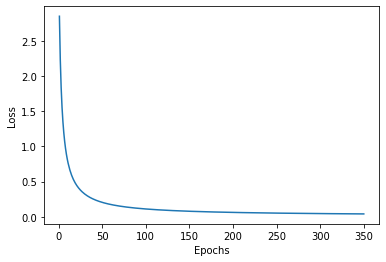

Resnet56 K80

beta0 = 0.04511230388724817
beta1 = 0.2740753117838543
beta2 = 2.5944122123303368e-20


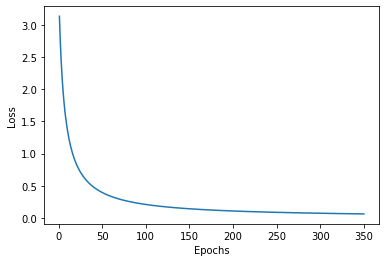

Resnet56 RTX8000

beta0 = 0.06276030538937287
beta1 = 0.2679576011029447
beta2 = 1.6852149363873487e-21


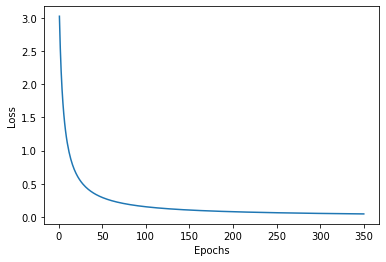

Resnet56 V100

beta0 = 0.10001267734486002
beta1 = 0.23904110117679275
beta2 = 0.014100852711507697


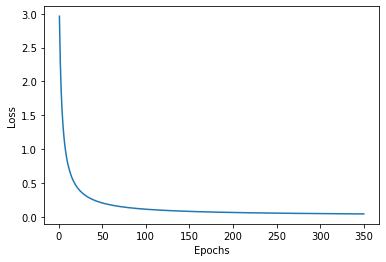

In [87]:
import json
from scipy.optimize import curve_fit
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

gpus = ["K80", "RTX8000", "V100"]
depths = ["14", "20", "32", "44", "56"]

def optimus_func(k, b0, b1, b2):
    return 1/(b0*k + b1) + b2

metrics = {d: {} for d in depths}

epoch = np.arange(1, 351)

def output(model,gpu):
    
    beta0 = metrics[model][gpu]['optimus_params'][0]
    print("beta{} = {}".format(0,beta0))
    beta1 = metrics[model][gpu]['optimus_params'][1]
    print("beta{} = {}".format(1,beta1))
    beta2 = metrics[model][gpu]['optimus_params'][2]
    print("beta{} = {}".format(2,beta2))
        
    plt.plot(epoch, optimus_func(epoch, beta0, beta1, beta2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

for depth in depths:
    for gpu in gpus:
        with open(f"results/results/HW4_Q4_depth{depth}_gpu{gpu}.json", "r") as f:
            data = json.load(f)
        
        metrics[depth][gpu] = data
        
        
        k = np.array(list(range(1, 351)))
        l = data["train_loss"]
        metrics[depth][gpu]["optimus_params"], _ = curve_fit(optimus_func, k, l, bounds=(0, np.inf))
        
        print("Resnet"+depth+" "+gpu+"\n")
        output(depth,gpu)

## Q4.2

### Regression Model for the parameters as a function of GPU and depth

In [88]:
from scipy import optimize
from sklearn import linear_model

In [89]:
def regression(B):
    
    for gpu in gpus:
    
        print("Regression for beta{} of {}".format(str(B),gpu))

        model=linear_model.LinearRegression()

        beta = [metrics[depth][gpu]["optimus_params"][B] for depth in depths]
        model.fit([[int(depth)] for depth in depths], beta)
        b = model.intercept_
        k = model.coef_

        print("m = {}, b = {}".format(k[0], b))

        dep = [int(depth) for depth in depths]
        predict = [k * x + b for x in dep]

        plt.plot(depths, predict)
        plt.scatter(depths, beta)
        plt.show()
    
    return model

Regression for beta0 of K80
m = -0.0068927107684281915, b = 0.4036507141004452


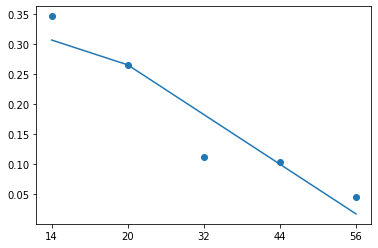

Regression for beta0 of RTX8000
m = -0.006522354257296324, b = 0.4161849373054035


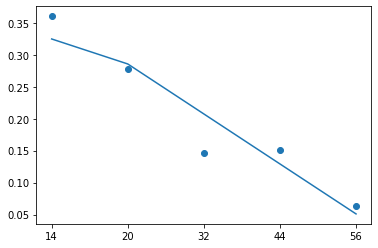

Regression for beta0 of V100
m = -0.006254888692849943, b = 0.4122870861416701


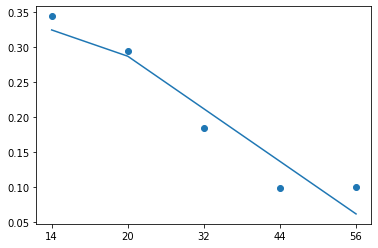

In [90]:
model_beta0 = regression(0)

Regression for beta1 of K80
m = 0.0004958407733241092, b = 0.23842048357270837


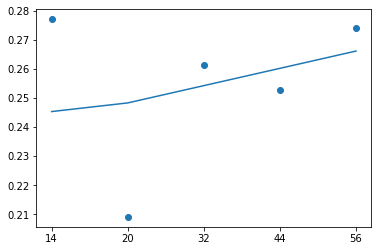

Regression for beta1 of RTX8000
m = 0.00010041682800576655, b = 0.23071978210516703


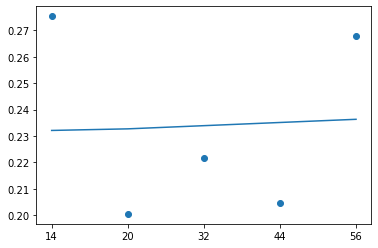

Regression for beta1 of V100
m = -0.00014929443535612204, b = 0.24213386871050271


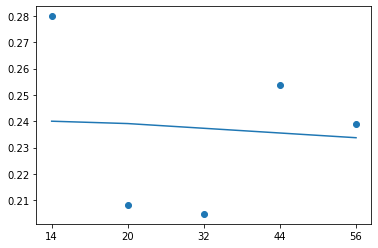

In [91]:
model_beta1 = regression(1)

Regression for beta2 of K80
m = -0.0011709275301103415, b = 0.0627293058699035


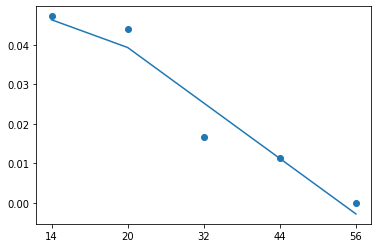

Regression for beta2 of RTX8000
m = -0.0009959262472701252, b = 0.0630077802516416


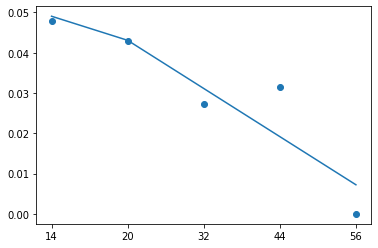

Regression for beta2 of V100
m = -0.0009360692319191202, b = 0.06190659930422274


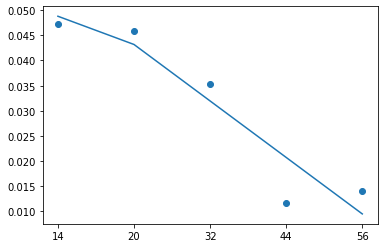

In [92]:
model_beta2 = regression(2)

### Prediction for Resnet50 parameters

In [93]:
beta0_50 = model_beta0.predict([[50]])
print("resnet50 beta0 = "+str(beta0_50[0]))

resnet50 beta0 = 0.09954265149917291


In [94]:
beta1_50 = model_beta1.predict([[50]])
print("resnet50 beta1 = "+str(beta1_50[0]))

resnet50 beta1 = 0.2346691469426966


In [95]:
beta2_50 = model_beta2.predict([[50]])
print("resnet50 beta2 = "+str(beta2_50[0]))

resnet50 beta2 = 0.015103137708266726


### Prediction for Resnet50 loss curve vs Actual Training loss

In [96]:
with open(f"results/results/HW4_Q4_depth50_gpuV100.json", "r") as f:
    data = json.load(f)

In [97]:
data

{'train_accuracy': [16.37799835205078,
  25.118000030517578,
  32.28199768066406,
  39.1619987487793,
  43.68000030517578,
  48.08399963378906,
  51.269996643066406,
  54.1400032043457,
  56.83399963378906,
  60.01599884033203,
  62.900001525878906,
  66.11799621582031,
  68.68199920654297,
  71.62199401855469,
  73.63399505615234,
  76.35600280761719,
  78.61399841308594,
  80.3479995727539,
  81.98799896240234,
  83.84599304199219,
  84.23599243164062,
  86.11199951171875,
  83.95599365234375,
  87.1199951171875,
  89.45999908447266,
  90.75,
  91.02400207519531,
  91.2959976196289,
  93.12200164794922,
  92.75599670410156,
  93.75599670410156,
  93.9939956665039,
  94.22799682617188,
  93.99799346923828,
  94.88600158691406,
  95.04999542236328,
  94.90799713134766,
  95.16199493408203,
  95.3219985961914,
  95.56600189208984,
  95.48600006103516,
  95.54399871826172,
  95.64199829101562,
  96.03799438476562,
  95.74600219726562,
  95.6719970703125,
  96.12199401855469,
  95.9879989

Till 92% accuracy

In [98]:
train_loss = np.array(data['train_loss'])
train_acc = np.array(data['train_accuracy'])
train_loss = train_loss[train_acc<92]
n = len(train_loss)

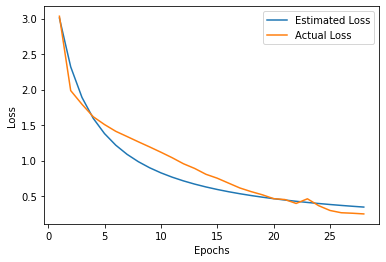

In [111]:
plt.plot(epoch[:n], optimus_func(epoch, beta0_50, beta1_50, beta2_50)[:n], label="Estimated Loss")
plt.plot(epoch[:n], train_loss, label="Actual Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

### Percentage Error

In [100]:
error = np.mean(np.abs(np.array(data["train_loss"]) - optimus_func(epoch, beta0_50, beta1_50, beta2_50)))
print("Error = {}%".format(np.round(100*error,2)))

Error = 3.66%


## Q4.3

Value of theta from the paper

In [101]:
theta0 = 1.02
theta1 = 2.78
theta2 = 4.92
theta3 = 0.00
theta4 = 0.02
M = 128

In [102]:
def f(p, w):
    return 1/(theta0*M/w+theta1+theta2*w/p+theta3*w+theta4*p)

In [103]:
workers = np.arange(1,21)

In [104]:
speed_2 = f(2, workers)
speed_4 = f(4, workers)

In [105]:
time_2 = n/speed_2
time_4 = n/speed_4

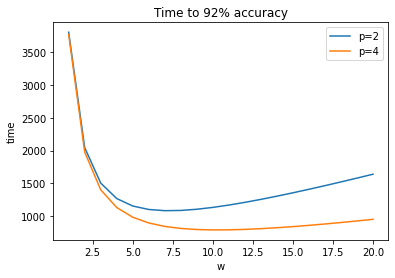

In [106]:
p2 = plt.plot(workers, time_2)
p4 = plt.plot(workers, time_4)
plt.title("Time to 92% accuracy")
plt.xlabel("w")
plt.ylabel("time")
plt.legend(labels = ['p=2', 'p=4'], loc = 'best')

plt.show()